In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.distributions import Categorical
import numpy as np

In [2]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(device)

cuda:0


In [3]:
with open('input.txt', 'r') as f:
  data = f.read()

In [4]:
chars = sorted(list(set(data)))
data_size, vocab_size = len(data), len(chars)
print('Total number of characters:', data_size)
print('Number of unique characters:', vocab_size)

Total number of characters: 1115393
Number of unique characters: 65


In [5]:
# char to int and int to char maps
char_to_int = {ch:i for i,ch in enumerate(chars)}
int_to_char = {i:ch for i,ch in enumerate(chars)}

In [6]:
# convert data from chars to indices
data = list(data)
for i, ch, in enumerate(data):
  data[i] = char_to_int[ch]

data = torch.tensor(data).to(device)
data = torch.unsqueeze(data, dim=1)    

In [44]:
int_to_char[data[0].item()]

'F'

In [7]:
class CharRNN(nn.Module):
    def __init__(self, input_size, output_size, hidden_size, num_layers):
        super(CharRNN, self).__init__()
        self.embedding = nn.Embedding(input_size, input_size)
        self.rnn = nn.LSTM(input_size=input_size, hidden_size=hidden_size, num_layers=num_layers)
        self.decoder = nn.Linear(hidden_size, output_size)
    
    def forward(self, input_seq, hidden_state):
        embedding = self.embedding(input_seq)
        output, hidden_state = self.rnn(embedding, hidden_state)
        output = self.decoder(output)
        return output, (hidden_state[0].detach(), hidden_state[1].detach())

In [8]:
# model
hidden_size = 512
num_layers = 3
learning_rate = 0.001
rnn = CharRNN(vocab_size, vocab_size, hidden_size, num_layers).to(device)

In [9]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(rnn.parameters(), lr=learning_rate)
epochs = 5
batch_size = 100

In [10]:
def train(net, epochs, data, batch_size, optimizer, criterion, print_every=2000):
  print('[epoch, batch, \tloss]')
  perplexity = []
  for epoch in range(epochs):
    n = 0
    running_loss = 0.0
    hidden_state = None
    
    # either start from 0 every time, or start on one of the first 100 letters
    #data_ptr = 0
    data_ptr = np.random.randint(batch_size)

    while True:
      input_seq = data[data_ptr : data_ptr + batch_size]
      target_seq = data[data_ptr + 1: data_ptr + batch_size + 1]

      optimizer.zero_grad()

      output, hidden_state = rnn(input_seq, hidden_state)
      loss = criterion(torch.squeeze(output), torch.squeeze(target_seq))      
      loss.backward()
      optimizer.step()

      running_loss += loss.item()
      # calculating perplexity
      # loss.item()??
      perplexity.append(torch.exp(loss))

      data_ptr += batch_size
      
      if n % print_every == (print_every-1):    
        print(f'[{epoch+1}, {n+1}, \t{running_loss/print_every}]')
        running_loss = 0.0
      n += 1
      if data_ptr + batch_size + 1 > data_size:
        break

  return perplexity
      

In [11]:

perplexity = train(rnn, epochs, data, batch_size, optimizer, loss_fn, 2000)
torch.save(rnn.state_dict(), 'charRNN_ 5epochs_3layers_random.pth')


[epoch, batch, 	loss]
[1, 2000, 	1.9731720856428145]
[1, 4000, 	1.5177883839607238]
[1, 6000, 	1.4747926640808582]
[1, 8000, 	1.41551407122612]
[1, 10000, 	1.3723158878982067]
[2, 2000, 	1.334270913630724]
[2, 4000, 	1.275072966337204]
[2, 6000, 	1.3172644697129727]
[2, 8000, 	1.2973911046087743]
[2, 10000, 	1.2746853843033314]
[3, 2000, 	1.2576277147233486]
[3, 4000, 	1.2074905719459057]
[3, 6000, 	1.2598988971412182]
[3, 8000, 	1.2476230304837226]
[3, 10000, 	1.2308437614440917]
[4, 2000, 	1.2217627874612809]
[4, 4000, 	1.1761452516913413]
[4, 6000, 	1.2286233653724195]
[4, 8000, 	1.222944752216339]
[4, 10000, 	1.2082074275910855]
[5, 2000, 	1.200659190505743]
[5, 4000, 	1.1567650269269942]
[5, 6000, 	1.2103614961206912]
[5, 8000, 	1.204769636452198]
[5, 10000, 	1.1948914560973645]


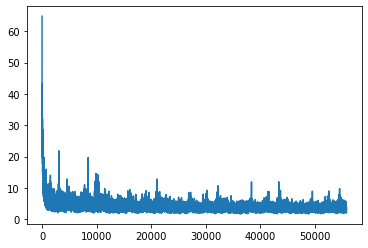

In [31]:
plt.plot(torch.FloatTensor(perplexity))
plt.show()

In [12]:
def generate(input_text, output_lenght=200):
  input = list(input_text)

  for i, ch, in enumerate(input):
    input[i] = char_to_int[ch]

  input = torch.tensor(input).to(device)
  input = torch.unsqueeze(input, dim=1) 


  # use input to build up hidden state
  hidden_state = None
  for i in range(len(input)-1):
    input_seq = input[i].unsqueeze(dim=0)
    _, hidden_state = rnn(input_seq, hidden_state)
    
    # print input character
    print(int_to_char[input[i].item()], end = '')


  # use the build-up hidden state and the last character in the given input 
  # text as first input to generate new text

  input_seq = input[-1].unsqueeze(dim=0)
  print(int_to_char[input[-1].item()], end = '')

  for _ in range(output_lenght):
    # forward pass
    output, hidden_state = rnn(input_seq, hidden_state)

    # construct categorial distribution and sample a character
    output = F.softmax(torch.squeeze(output), dim=0)
    distribution = Categorical(output)
    index = distribution.sample()

    # print the sampled character
    print(int_to_char[index.item()], end = '')
    
    # want input_seq in the format ([[x]], cuda)
    input_seq = index.unsqueeze(dim=0).unsqueeze(dim=0)


In [46]:
# Task 2
# code that create a 5-char long sequence from vocab
str = ''
for i in range(5):
  str += int_to_char[np.random.randint(vocab_size)]

print(str)

generate(str, 100)

Cwy d
Cwy does
Fooling to some time?

LONDH:
Thou shalt not.

ANTONIO:
No longeth of it is wonty, I do; 'tis mo

In [50]:
generate('The', 100)

The:
Sir, that I live.

GONZALO:
Osses upon thine ear?

ANTONIO:

ANTONIO:
As by love in his great quee

In [52]:
generate('Shall I give ')

Shall I give us cast.

DUKE VINCENTIO:
Sir, we are forth; look upon the corn,
That thou lightst, since, one than our sacred
With something severy.

ANTONIO:
I have no more made your mouths, thither
Were not some d

In [51]:
generate('What is ', 400)

What is wrection
He hath entertained these worst swift poison rocks.
And, 'Some son! the hound ta'en, a dotey?

PROSPERO:
What like my father, and
I am content with stolens?

ALONSO:
O boanish! what it is the walk'd done?

FERDINAND:
My husband's majely wrought
From this govern sight.

BADNAND:
Sir, sir: and I with his wave did look no view.

BAPTISTA:
I said quality for man,--

SEBASTIAN:
Laze, i' the fa

In [56]:
generate('XhNYB BHN BYFVuhsdbs')

XhNYB BHN BYFVuhsdbsawn!

ANTONIO:
Fie, he must have now gone,
Were not for my castice boltly.

ANTONIO:
No, master.
When with boister that our arty solling, nor
mathous party? nay; for my cheat such a safflet.

HORTENSI